<a href="https://colab.research.google.com/github/mcalmeida13/machine_learning_examples/blob/master/starbucks_customer_segmentation/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install lifetimes
!pip install -U yellowbrick

     |████████████████████████████████| 584 kB 4.1 MB/s 


In [3]:
import pandas as pd
import numpy as np
# import math
# import json
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
% matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from yellowbrick.cluster.elbow import kelbow_visualizer
# Functions that calculates rfm quantities
from lifetimes.utils import summary_data_from_transaction_data

## Dataset

The data is contained in three files:

- `portfolio.json` - containing offer ids and meta data about each offer (duration, type, etc.)

- `profile.json` - demographic data for each customer

- `transcript.json` - records for transactions, offers received, offers viewed, and offers completed

In [4]:
path_portfolio = 'https://raw.githubusercontent.com/seifip/starbucks-customer-segmentation/master/data/portfolio.json'
path_profile = 'https://raw.githubusercontent.com/seifip/starbucks-customer-segmentation/master/data/profile.json'
path_transcript = 'https://raw.githubusercontent.com/seifip/starbucks-customer-segmentation/master/data/transcript.json'

In [5]:
portfolio = pd.read_json(path_portfolio, orient='records', lines=True)
profile = pd.read_json(path_profile, orient='records', lines=True)
transcript = pd.read_json(path_transcript, orient='records', lines=True)

## Portfolio
- `id (string)` - offer id
- `offer_type (string)` - type of offer: BOGO*, discount, informational
- `difficulty (int)` - minimum required spend to complete an offer
- `reward (int)` - reward given for completing an offer
- `duration (int)` - time for offer to be open in days
- `channels (list of strings)` -  channels the costumer had contact

*Buy-one-get-one (BOGO)

In [6]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


## Transcript

- `event (str)` - record description: 'offer received', 'offer viewed', 'transaction', 'offer completed'
- `person (str)` - customer id
- `time (int)` - time in hours since start of test. The data begins at time t=0
- `value - (dict of strings)` - either an offer id or transaction amount depending on the record

In [8]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [9]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


## Profile

- `age (int)` - age of the customer
- `became_member_on (int)` - date when customer created an app account
- `gender (str)` - gender of the customer (note some entries contain 'O' for other rather than M or F)
- `id (str)` - customer id
- `income (float)` - customer's income

In [10]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


## Data type

In [12]:
# became_member_on must be a date
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format="%Y%m%d")

In [13]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


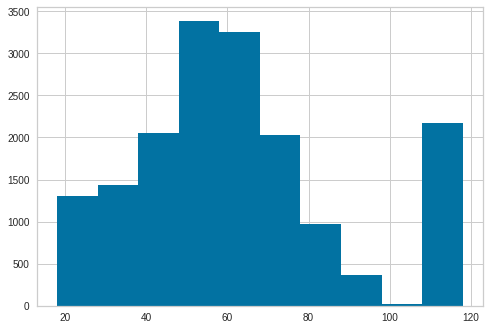

In [14]:
# plot age distribution
plt.hist(profile['age'])
plt.show()

In [15]:
# fill `NaN` gender with "NA"
profile['gender'] = profile['gender'].fillna('not_informed')

In [16]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            17000 non-null  object        
 1   age               17000 non-null  int64         
 2   id                17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


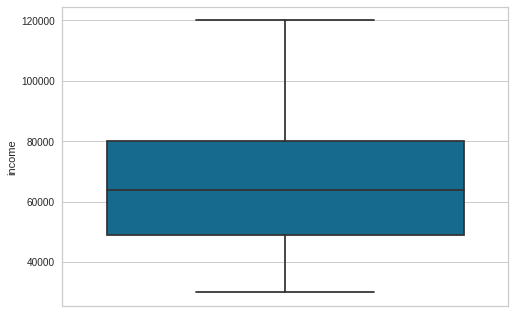

In [17]:
# plot a boxplot from income's distribuition
ax = sns.boxplot(y=profile["income"])

In [18]:
profile.describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


In [19]:
# Unique genders
profile['gender'].unique()

array(['not_informed', 'F', 'M', 'O'], dtype=object)

In [20]:
# fill `NaN` income with the median
profile['income_na'] = profile['income'].isna().astype(int)
# criar uma coluna para sinalizar que o valor da coluna foi inputado para remover o Null
profile['income'] = profile['income'].fillna(profile['income'].median())

In [21]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

## Categorical data into numerical

Turn the columns `portfolio['channels'],portfolio['offer_type'],profile['gender'],transcription['event']` into multiple columns one-hot encoded 

In [22]:
# Let's see what informations an portfolio have
portfolio.head(1)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd


###Channels

In [23]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

In [24]:
# Let's see what MultiLabelBinarizer returns
portfolio['channels'].head(1)

0    [email, mobile, social]
Name: channels, dtype: object

In [25]:
mlb.fit(portfolio['channels'].head(1))
# it has a method to return the unique classes
mlb.classes_

array(['email', 'mobile', 'social'], dtype=object)

In [26]:
#Fit the MultiLabelBinarizer from all data
channels = mlb.fit_transform(portfolio['channels'])

In [27]:
#Get the classes
classes = mlb.classes_

In [28]:
#Transform the classes into a dataset 
channel_dummies = pd.DataFrame(channels, columns= classes,index = portfolio.index)
channel_dummies.head()

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1


### Offers

In [29]:
offer_dummy = portfolio['offer_type'].str.get_dummies()
offer_dummy.head()

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0


In [30]:
#putting all together
portfolio_clean = pd.concat([portfolio,channel_dummies,offer_dummy], axis=1)

portfolio_clean.head()

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


### Year joined

In [31]:
profile['year_joined'] = profile['became_member_on'].apply(lambda x: str(x.year))
year_joined_dummies = profile['year_joined'].str.get_dummies().add_prefix('year_joined_')

### Gender

In [32]:
#One-hot encoding gender
gender_dummies = profile['gender'].str.get_dummies().add_prefix('gender_')

### Putting all together

In [33]:
profile_v2 = pd.concat([profile,gender_dummies,year_joined_dummies], axis=1)
profile_v2.drop(['became_member_on'], axis=1, inplace=True)
profile_v2.drop(['year_joined'], axis=1, inplace=True)
profile_v2.head()

,gender,age,id,income,income_na,gender_F,gender_M,gender_O,gender_not_informed,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,not_informed,118,68be06ca386d4c31939f3a4f0e3dd783,64000.0,1,0,0,0,1,0,0,0,0,1,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,0,1,0,0,0,0,0,0,0,1,0
2,not_informed,118,38fe809add3b4fcf9315a9694bb96ff5,64000.0,1,0,0,0,1,0,0,0,0,0,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,1,0,0,0,0,0,0,0,1,0
4,not_informed,118,a03223e636434f42ac4c3df47e8bac43,64000.0,1,0,0,0,1,0,0,0,0,1,0


### Event

In [34]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [35]:
# transcript.head()
event_dummies = transcript['event'].str.get_dummies()
event_dummies.head()

,offer completed,offer received,offer viewed,transaction
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [36]:
new_names = {
  'offer completed':'offer_completed'
  ,'offer received':'offer_received'
  ,'offer viewed':'offer_viewed'
}

event_dummies.rename(columns = new_names, inplace=True)
event_dummies.head()

,offer_completed,offer_received,offer_viewed,transaction
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [37]:
transcript = pd.concat([transcript, event_dummies], axis=1)
transcript.head()

,person,event,value,time,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0


## Split offers and transactions into two dataframes

In [38]:
transcript[transcript['event'] == 'transaction'].head()

,person,event,value,time,offer_completed,offer_received,offer_viewed,transaction
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0,0,0,1
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,0,0,0,1
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,0,0,0,1
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,0,0,0,1
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,0,0,0,1


In [39]:
example = {'amount': 0.8300000000000001}	
list(transcript['value'][0].values())[0]

'9b98b8c7a33c4b65b9aebfe6a799e6d9'

In [40]:
# Transaction
transactions = transcript[transcript['event'] == 'transaction'].copy()
transactions['amount'] = transactions['value'].apply(lambda x: list(x.values())[0])
transactions.drop(['value','offer_completed', 'offer_received','offer_viewed','transaction'],axis=1,inplace=True)
transactions.head()

,person,event,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97


In [41]:
# Offers
offers = transcript[transcript['event'] != 'transaction'].copy()
offers['offer_id'] = offers['value'].apply(lambda x: list(x.values())[0])
offers.drop(['value','transaction'],axis=1,inplace=True)
offers.head()

,person,event,time,offer_completed,offer_received,offer_viewed,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,1,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,1,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0


# Merge dataframes

To merge all dataframes, we must identify which ids connect the dataframe

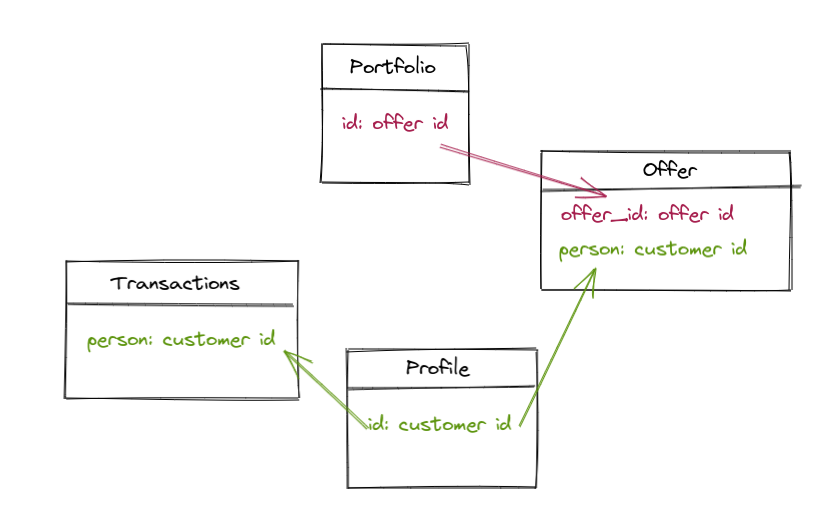

Let's do the followoing strategy

1) Rename `portfolio['id']` into `portfolio['offer_id']`

2) Rename `profile['id']` into `profile['person']`

3) Merge left `offers` with `profile` by `person` key

4) Merge left `offers` with `portfolio` by `offer_id` key

5) Merge left `transactions` with `profile` by `person` key

In [42]:
# 1) Rename portfolio['id'] into portfolio['offer_id']


portfolio_clean.rename(columns={'id':'offer_id'}, inplace=True)
portfolio_clean.head()

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


In [43]:
# 2) Rename `profile['id']` into `profile['person']`

profile_v2.rename(columns={'id':'person'}, inplace=True)
profile_v2.head()

,gender,age,person,income,income_na,gender_F,gender_M,gender_O,gender_not_informed,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,not_informed,118,68be06ca386d4c31939f3a4f0e3dd783,64000.0,1,0,0,0,1,0,0,0,0,1,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,0,1,0,0,0,0,0,0,0,1,0
2,not_informed,118,38fe809add3b4fcf9315a9694bb96ff5,64000.0,1,0,0,0,1,0,0,0,0,0,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,1,0,0,0,0,0,0,0,1,0
4,not_informed,118,a03223e636434f42ac4c3df47e8bac43,64000.0,1,0,0,0,1,0,0,0,0,1,0


In [44]:
# 3) Merge left `offers` with `profile` by `person` key

offers_v2 = offers.merge(profile_v2, left_on='person',right_on='person')
offers_v2.head()

,person,event,time,offer_completed,offer_received,offer_viewed,offer_id,gender,age,income,income_na,gender_F,gender_M,gender_O,gender_not_informed,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,0,1,0,5a8bc65990b245e5a138643cd4eb9837,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0
4,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,0,0,1,5a8bc65990b245e5a138643cd4eb9837,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0


In [45]:
# 4) Merge left `offers` with `portfolio` by `offer_id` key

offers_v3 = offers_v2.merge(portfolio_clean,left_on='offer_id', right_on='offer_id')
offers_v3.head()

,person,event,time,offer_completed,offer_received,offer_viewed,offer_id,gender,age,income,income_na,gender_F,gender_M,gender_O,gender_not_informed,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,reward,channels,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0
3,e2127556f4f64592b11af22de27a7932,offer received,408,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,70000.0,0,0,1,0,0,0,0,0,0,0,1,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,70000.0,0,0,1,0,0,0,0,0,0,0,1,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0


In [46]:
offers_v3.shape

(167581, 33)

In [47]:
# 5) Merge left `transactions` with `profile` by `person` key

transactions_v2 = transactions.merge(profile_v2, left_on='person', right_on='person')
# transactions_v2.drop(['event','became_member_on'], axis=1, inplace=True)
transactions_v2.head()

,person,event,time,amount,gender,age,income,income_na,gender_F,gender_M,gender_O,gender_not_informed,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,F,20,30000.0,0,1,0,0,0,0,0,0,1,0,0
1,02c083884c7d45b39cc68e1314fec56c,transaction,6,1.44,F,20,30000.0,0,1,0,0,0,0,0,0,1,0,0
2,02c083884c7d45b39cc68e1314fec56c,transaction,12,4.56,F,20,30000.0,0,1,0,0,0,0,0,0,1,0,0
3,02c083884c7d45b39cc68e1314fec56c,transaction,84,1.53,F,20,30000.0,0,1,0,0,0,0,0,0,1,0,0
4,02c083884c7d45b39cc68e1314fec56c,transaction,90,0.50,F,20,30000.0,0,1,0,0,0,0,0,0,1,0,0


In [48]:
transactions_v2.shape

(138953, 18)

In [49]:
transactions_v2.columns

Index(['person', 'event', 'time', 'amount', 'gender', 'age', 'income',
       'income_na', 'gender_F', 'gender_M', 'gender_O', 'gender_not_informed',
       'year_joined_2013', 'year_joined_2014', 'year_joined_2015',
       'year_joined_2016', 'year_joined_2017', 'year_joined_2018'],
      dtype='object')

# Drop outiliers

In [50]:
profile_v2= profile_v2.query('age <=99')
offers_v3 = offers_v3.query('age <=99')
transactions_v2 = transactions_v2.query('age <=99')

In [51]:
transactions_v2.describe()

,time,amount,age,income,income_na,gender_F,gender_M,gender_O,gender_not_informed,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
count,123802.000000,123802.000000,123802.000000,123802.000000,123802.0,123802.000000,123802.000000,123802.000000,123802.0,123802.000000,123802.000000,123802.000000,123802.000000,123802.000000,123802.000000
mean,381.255941,13.990337,52.654384,61831.012423,0.0,0.397910,0.587793,0.014297,0.0,0.027528,0.066097,0.141581,0.251660,0.355390,0.157744
std,201.815431,31.767386,17.838467,20656.130481,0.0,0.489469,0.492234,0.118713,0.0,0.163616,0.248453,0.348621,0.433969,0.478633,0.364502
min,0.000000,0.050000,18.000000,30000.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,210.000000,3.660000,39.000000,46000.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,402.000000,10.790000,54.000000,60000.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,552.000000,19.120000,65.000000,74000.000000,0.0,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,714.000000,1062.280000,99.000000,120000.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
# a mesma oferta pode ser vista e recebida várias vezes
#vamos eliminar as duplicadas

offers_v3[offers_v3.duplicated(subset=['offer_id','person'], keep=False)].head()

,person,event,time,offer_completed,offer_received,offer_viewed,offer_id,gender,age,income,income_na,gender_F,gender_M,gender_O,gender_not_informed,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,reward,channels,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0
3,e2127556f4f64592b11af22de27a7932,offer received,408,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,70000.0,0,0,1,0,0,0,0,0,0,0,1,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,70000.0,0,0,1,0,0,0,0,0,0,0,1,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0


# A trick

In order to differentiate the time when the user did some action in the offer, we will add 0.5 quantity to diferetiate between seen at time =0 and not seen

In [53]:
offers_v3['time'] = offers_v3['time'] + 0.5
offers_v3['received_time'] = offers_v3['offer_received'] * offers_v3['time']
offers_v3['viewed_time'] = offers_v3['offer_viewed'] * offers_v3['time']
offers_v3['completed_time'] = offers_v3['offer_completed'] * offers_v3['time']

In [54]:
offers_v3.head()

,person,event,time,offer_completed,offer_received,offer_viewed,offer_id,gender,age,income,income_na,gender_F,gender_M,gender_O,gender_not_informed,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,reward,channels,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational,received_time,viewed_time,completed_time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.5,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0,0.5,0.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6.5,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0,0.0,6.5,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132.5,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0,0.0,0.0,132.5
3,e2127556f4f64592b11af22de27a7932,offer received,408.5,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,70000.0,0,0,1,0,0,0,0,0,0,0,1,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0,408.5,0.0,0.0
4,e2127556f4f64592b11af22de27a7932,offer viewed,420.5,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,70000.0,0,0,1,0,0,0,0,0,0,0,1,5,"[web, email, mobile]",5,7,bogo,1,1,0,1,1,0,0,0.0,420.5,0.0


In [55]:
#vamos trackear o número de vezes que a pessoa foi exposta ao mesmo anuncio
# primeira oferta
offers_min = offers_v3.groupby(['person','offer_id','event']).min()
offers_min.head()

time  ...  completed_time
person                           offer_id                         event                   ...                
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed  576.5  ...           576.5
                                                                  offer received   576.5  ...             0.0
                                 3f207df678b143eea3cee63160fa8bed offer received   336.5  ...             0.0
                                                                  offer viewed     372.5  ...             0.0
                                 5a8bc65990b245e5a138643cd4eb9837 offer received   168.5  ...             0.0

[5 rows x 33 columns]

In [56]:
# soma do número de propostas recebidas
offers_sums = offers_v3.groupby(['person','offer_id','event'])[['offer_received', 'offer_viewed', 'offer_completed']].sum()
offers_sums.head()

offer_received  ...  offer_completed
person                           offer_id                         event                            ...                 
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed               0  ...                1
                                                                  offer received                1  ...                0
                                 3f207df678b143eea3cee63160fa8bed offer received                1  ...                0
                                                                  offer viewed                  0  ...                0
                                 5a8bc65990b245e5a138643cd4eb9837 offer received                1  ...                0

[5 rows x 3 columns]

In [57]:
offers_min.update(offers_sums)
offers_min.head()

time  ...  completed_time
person                           offer_id                         event                   ...                
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 offer completed  576.5  ...           576.5
                                                                  offer received   576.5  ...             0.0
                                 3f207df678b143eea3cee63160fa8bed offer received   336.5  ...             0.0
                                                                  offer viewed     372.5  ...             0.0
                                 5a8bc65990b245e5a138643cd4eb9837 offer received   168.5  ...             0.0

[5 rows x 33 columns]

In [58]:
offers_grouped = offers_min.groupby(['person', 'offer_id']).max().reset_index()
offers_grouped.head()

,person,offer_id,time,offer_completed,offer_received,offer_viewed,gender,age,income,income_na,gender_F,gender_M,gender_O,gender_not_informed,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,reward,channels,difficulty,duration,offer_type,email,mobile,social,web,bogo,discount,informational,received_time,viewed_time,completed_time
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.5,1,1,0,M,33,72000.0,0,0,1,0,0,0,0,0,0,1,0,2,"[web, email, mobile]",10,7,discount,1,1,0,1,0,1,0,576.5,0.0,576.5
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372.5,0,1,1,M,33,72000.0,0,0,1,0,0,0,0,0,0,1,0,0,"[web, email, mobile]",0,4,informational,1,1,0,1,0,0,1,336.5,372.5,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192.5,0,1,1,M,33,72000.0,0,0,1,0,0,0,0,0,0,1,0,0,"[email, mobile, social]",0,3,informational,1,1,1,0,0,0,1,168.5,192.5,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456.5,1,1,1,M,33,72000.0,0,0,1,0,0,0,0,0,0,1,0,5,"[web, email, mobile, social]",5,5,bogo,1,1,1,1,1,0,0,408.5,456.5,414.5
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540.5,1,1,1,M,33,72000.0,0,0,1,0,0,0,0,0,0,1,0,2,"[web, email, mobile, social]",10,10,discount,1,1,1,1,0,1,0,504.5,540.5,528.5


In [59]:
offers_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55163 entries, 0 to 55162
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   person               55163 non-null  object 
 1   offer_id             55163 non-null  object 
 2   time                 55163 non-null  float64
 3   offer_completed      55163 non-null  int64  
 4   offer_received       55163 non-null  int64  
 5   offer_viewed         55163 non-null  int64  
 6   gender               55163 non-null  object 
 7   age                  55163 non-null  int64  
 8   income               55163 non-null  float64
 9   income_na            55163 non-null  int64  
 10  gender_F             55163 non-null  int64  
 11  gender_M             55163 non-null  int64  
 12  gender_O             55163 non-null  int64  
 13  gender_not_informed  55163 non-null  int64  
 14  year_joined_2013     55163 non-null  int64  
 15  year_joined_2014     55163 non-null 

# Drop misattribuitions

In [60]:
#Valid offers are the ones sent during the 30-day test period
# vamos criar um coluna que calcula qual devereia ser o encerramento do período de teste
offers_grouped['end_time'] = offers_grouped['received_time'] + offers_grouped['duration']

In [61]:
#verificar se viram o anuncio antes do final dele
offers_grouped['viewed_on_time'] = offers_grouped.apply(lambda x: 1 if x['viewed_time'] < x['end_time'] else 0, axis=1)

In [62]:
#veridfficar se fecahram a compra antes do final do anúncio
offers_grouped['completed_on_time'] = offers_grouped.apply(lambda x: 1 if x['completed_time'] < x['end_time'] else 0, axis=1)

In [63]:
# dropping misattributions
# completion without view
offers_grouped = offers_grouped.query('~(completed_time > 0 and viewed_time == 0)')
# completion before view
offers_grouped = offers_grouped.query('~(completed_time != 0 and completed_time < viewed_time)')
# view before receive
offers_grouped = offers_grouped.query('~(viewed_time != 0 and viewed_time < received_time)')

In [64]:
offers_grouped.shape

(47067, 38)

In [65]:
offers_grouped.columns

Index(['person', 'offer_id', 'time', 'offer_completed', 'offer_received',
       'offer_viewed', 'gender', 'age', 'income', 'income_na', 'gender_F',
       'gender_M', 'gender_O', 'gender_not_informed', 'year_joined_2013',
       'year_joined_2014', 'year_joined_2015', 'year_joined_2016',
       'year_joined_2017', 'year_joined_2018', 'reward', 'channels',
       'difficulty', 'duration', 'offer_type', 'email', 'mobile', 'social',
       'web', 'bogo', 'discount', 'informational', 'received_time',
       'viewed_time', 'completed_time', 'end_time', 'viewed_on_time',
       'completed_on_time'],
      dtype='object')

# Recency & frequency

In [66]:
transactions_v2.head(1)

,person,event,time,amount,gender,age,income,income_na,gender_F,gender_M,gender_O,gender_not_informed,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
0,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,F,20,30000.0,0,1,0,0,0,0,0,0,1,0,0


In [67]:
# time to Datetime
transactions_v2['datetime'] = transactions_v2['time'].apply(lambda x: pd.Timestamp('2000-01-01T12') + pd.Timedelta(hours=x))
transactions_v2.head()

,person,event,time,amount,gender,age,income,income_na,gender_F,gender_M,gender_O,gender_not_informed,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,datetime
0,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,F,20,30000.0,0,1,0,0,0,0,0,0,1,0,0,2000-01-01 12:00:00
1,02c083884c7d45b39cc68e1314fec56c,transaction,6,1.44,F,20,30000.0,0,1,0,0,0,0,0,0,1,0,0,2000-01-01 18:00:00
2,02c083884c7d45b39cc68e1314fec56c,transaction,12,4.56,F,20,30000.0,0,1,0,0,0,0,0,0,1,0,0,2000-01-02 00:00:00
3,02c083884c7d45b39cc68e1314fec56c,transaction,84,1.53,F,20,30000.0,0,1,0,0,0,0,0,0,1,0,0,2000-01-05 00:00:00
4,02c083884c7d45b39cc68e1314fec56c,transaction,90,0.50,F,20,30000.0,0,1,0,0,0,0,0,0,1,0,0,2000-01-05 06:00:00


In [68]:
rf = summary_data_from_transaction_data(transactions_v2, 'person', 'datetime', monetary_value_col='amount')
rf.drop('T', axis=1, inplace=True)
rf.head()

,frequency,recency,monetary_value
person,,,
0009655768c64bdeb2e877511632db8f,6.0,19.0,17.573333
0011e0d4e6b944f998e987f904e8c1e5,3.0,21.0,21.990000
0020c2b971eb4e9188eac86d93036a77,6.0,28.0,29.871667
0020ccbbb6d84e358d3414a3ff76cffd,9.0,26.0,15.308889
003d66b6608740288d6cc97a6903f4f0,13.0,26.0,3.525385


In [69]:
profile_v2.set_index('person', inplace=True)
profile_v2.head()

,gender,age,income,income_na,gender_F,gender_M,gender_O,gender_not_informed,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018
person,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,0,1,0,0,0,0,0,0,0,1,0
78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0
e2127556f4f64592b11af22de27a7932,M,68,70000.0,0,0,1,0,0,0,0,0,0,0,1
389bc3fa690240e798340f5a15918d5c,M,65,53000.0,0,0,1,0,0,0,0,0,0,0,1
2eeac8d8feae4a8cad5a6af0499a211d,M,58,51000.0,0,0,1,0,0,0,0,0,0,1,0


In [70]:
customers = profile_v2.join(rf)
customers.head()

,gender,age,income,income_na,gender_F,gender_M,gender_O,gender_not_informed,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,frequency,recency,monetary_value
person,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,0,1,0,0,0,0,0,0,0,1,0,2.0,21.0,27.750000
78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0,5.0,16.0,24.320000
e2127556f4f64592b11af22de27a7932,M,68,70000.0,0,0,1,0,0,0,0,0,0,0,1,1.0,10.0,18.420000
389bc3fa690240e798340f5a15918d5c,M,65,53000.0,0,0,1,0,0,0,0,0,0,0,1,2.0,22.0,13.445000
2eeac8d8feae4a8cad5a6af0499a211d,M,58,51000.0,0,0,1,0,0,0,0,0,0,1,0,3.0,15.0,4.433333


# View & Conversition rate

- View Rate: Given a Received offers, how many offers were viewed?

view_rate(vr) = offers_views/offers_received

- Conversion Rate: Given a Viewed offers, how many conversions?

conversion_rate(cr) = offers_completed/offers_viewed



In [71]:
# some useful functions
def sum_greater_than_zero(x):
    """Counts non-0 items."""
    return (x > 0).sum()

def mean_greater_than_zero(x):
    """Average non-0 items."""
    return x.replace(0, np.nan).mean() 

## BOGO offers

In [72]:
bogo_performance = offers_grouped.query('offer_type == "bogo"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)

In [74]:
bogo_performance.head()

,offers_received_cnt,offers_viewed_cnt,offers_completed_cnt
person,,,
0011e0d4e6b944f998e987f904e8c1e5,1,1,1
0020c2b971eb4e9188eac86d93036a77,2,1,1
0020ccbbb6d84e358d3414a3ff76cffd,2,2,2
004b041fbfe44859945daa2c7f79ee64,1,1,1
004c5799adbf42868b9cff0396190900,1,1,1


In [75]:
#view rate
bogo_performance['bogo_vr'] = bogo_performance['offers_viewed_cnt'] / bogo_performance['offers_received_cnt']
# conversion rate
bogo_performance['bogo_cr'] = bogo_performance['offers_completed_cnt'] / bogo_performance['offers_viewed_cnt']
bogo_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

## discount offers

In [76]:
discount_performance = offers_grouped.query('offer_type == "discount"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
discount_performance['discount_vr'] = discount_performance['offers_viewed_cnt'] / discount_performance['offers_received_cnt']
discount_performance['discount_cr'] = discount_performance['offers_completed_cnt'] / discount_performance['offers_viewed_cnt']
discount_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# informational offers view rate

In [77]:
informational_performance = offers_grouped.query('offer_type == "informational"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
informational_performance['informational_vr'] = informational_performance['offers_viewed_cnt'] / informational_performance['offers_received_cnt']
informational_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# all offers conversion rate

In [78]:
total_performance = offers_grouped.query('offer_type != "informational"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),    
)
total_performance['total_cr'] = total_performance['offers_completed_cnt'] / total_performance['offers_viewed_cnt']
total_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# Putting all together

In [79]:
customers = customers.join(bogo_performance).join(discount_performance).join(informational_performance).join(total_performance)
customers.fillna(0, inplace=True)
customers.head()

,gender,age,income,income_na,gender_F,gender_M,gender_O,gender_not_informed,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,frequency,recency,monetary_value,bogo_vr,bogo_cr,discount_vr,discount_cr,informational_vr,total_cr
person,,,,,,,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,0,1,0,0,0,0,0,0,0,1,0,2.0,21.0,27.750000,0.0,0.0,0.0,0.0,0.0,0.000000
78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,0,1,0,0,0,0,0,0,0,1,0,5.0,16.0,24.320000,1.0,1.0,0.0,0.0,1.0,1.000000
e2127556f4f64592b11af22de27a7932,M,68,70000.0,0,0,1,0,0,0,0,0,0,0,1,1.0,10.0,18.420000,1.0,1.0,1.0,0.5,0.0,0.666667
389bc3fa690240e798340f5a15918d5c,M,65,53000.0,0,0,1,0,0,0,0,0,0,0,1,2.0,22.0,13.445000,1.0,1.0,1.0,1.0,0.0,1.000000
2eeac8d8feae4a8cad5a6af0499a211d,M,58,51000.0,0,0,1,0,0,0,0,0,0,1,0,3.0,15.0,4.433333,0.0,0.0,1.0,0.5,0.0,0.500000


In [82]:
customer_offers = offers_grouped.groupby('person').agg(
    reward_avg = ('reward', 'mean'),
    difficulty_avg = ('difficulty', 'mean'),
    email_cnt = ('email', 'sum'),
    mobile_cnt = ('mobile', 'sum'),
    social_cnt = ('social', 'sum'),
    web_cnt = ('web', 'sum'),
    bogo_cnt = ('bogo', 'sum'),
    discount_cnt = ('discount', 'sum'),
    informational_cnt = ('informational', 'sum'),
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),
    exposures_received_avg = ('offer_received', 'mean'),
    exposures_viewed_avg = ('offer_viewed', 'mean'),
    exposures_completed_avg = ('offer_completed', 'mean'),
)

customers_v2 = customers.join(customer_offers)

customers_v2.drop(['gender', 'gender_not_informed', 'income_na'], axis=1, inplace=True)
customers_v2.dropna(inplace=True)

customers_v2.head()

,age,income,gender_F,gender_M,gender_O,year_joined_2013,year_joined_2014,year_joined_2015,year_joined_2016,year_joined_2017,year_joined_2018,frequency,recency,monetary_value,bogo_vr,bogo_cr,discount_vr,discount_cr,informational_vr,total_cr,reward_avg,difficulty_avg,email_cnt,mobile_cnt,social_cnt,web_cnt,bogo_cnt,discount_cnt,informational_cnt,offers_received_cnt,offers_viewed_cnt,offers_completed_cnt,exposures_received_avg,exposures_viewed_avg,exposures_completed_avg
person,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55,112000.0,1,0,0,0,0,0,0,1,0,2.0,21.0,27.750000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1,0,0,0,0,0,0,1,0,5.0,16.0,24.320000,1.0,1.0,0.0,0.0,1.0,1.000000,5.000000,5.000000,3.0,3.0,2.0,1.0,2.0,0.0,1.0,3.0,3.0,2.0,1.0,1.000000,0.666667
e2127556f4f64592b11af22de27a7932,68,70000.0,0,1,0,0,0,0,0,0,1,1.0,10.0,18.420000,1.0,1.0,1.0,0.5,0.0,0.666667,2.250000,6.250000,4.0,4.0,1.0,4.0,1.0,2.0,1.0,4.0,3.0,2.0,1.0,0.750000,0.500000
389bc3fa690240e798340f5a15918d5c,65,53000.0,0,1,0,0,0,0,0,0,1,2.0,22.0,13.445000,1.0,1.0,1.0,1.0,0.0,1.000000,3.500000,7.500000,4.0,4.0,2.0,4.0,2.0,2.0,0.0,4.0,4.0,4.0,1.5,1.500000,1.250000
2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,0,1,0,0,0,0,0,1,0,3.0,15.0,4.433333,0.0,0.0,1.0,0.5,0.0,0.500000,1.666667,5.666667,3.0,3.0,2.0,3.0,0.0,2.0,1.0,3.0,2.0,1.0,1.0,0.666667,0.333333


In [85]:
customers.to_csv('customers.csv')

In [86]:
customers_v2.to_csv('customers_v2.csv')